epoch: 1 / 300 mean absolute error: training 112.13 bikes, validation: 114.86 bikes.
epoch: 11 / 300 mean absolute error: training 68.76 bikes, validation: 68.63 bikes.
epoch: 21 / 300 mean absolute error: training 56.52 bikes, validation: 56.59 bikes.
epoch: 31 / 300 mean absolute error: training 46.11 bikes, validation: 47.55 bikes.
epoch: 41 / 300 mean absolute error: training 41.15 bikes, validation: 42.88 bikes.
epoch: 51 / 300 mean absolute error: training 34.69 bikes, validation: 36.99 bikes.
epoch: 61 / 300 mean absolute error: training 37.11 bikes, validation: 37.68 bikes.
epoch: 71 / 300 mean absolute error: training 32.01 bikes, validation: 33.68 bikes.
epoch: 81 / 300 mean absolute error: training 35.28 bikes, validation: 37.54 bikes.
epoch: 91 / 300 mean absolute error: training 31.69 bikes, validation: 33.27 bikes.
epoch: 101 / 300 mean absolute error: training 35.04 bikes, validation: 37.37 bikes.
epoch: 111 / 300 mean absolute error: training 27.24 bikes, validation: 29

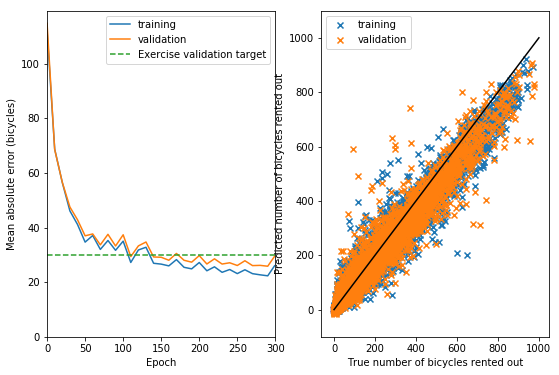

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

TRAIN_EPOCHS = 300  # The number of times the complete dataset is used to during training
BATCH_SIZE = 15  # Number of examples to use for calculating the gradient
LEARNING_RATE = 1e-3  # Scales the size of the parameter updates
L2_WEIGHT_LOSS = 0e-3  # Penalty on the size of the parameters, used for regularization

REPORT_INTERVAL = 60  # Report the learning progress once every number of epochs

TARGET_SIZE = 1  # target size
FEATURES = 11  # input size

FIG_SIZE = (9, 6)

"""
Basic tensorflow structure:

1. Make a session object tf.Session (which takes care of the background magic like placing things
in RAM / VRAM, computations with concurrency etc)

2. Define the computational graph:
    Consists of operations (ops), which take in tensors, these come from:
        - the outputs of other ops
        - variables (tf.Variable) [tensors stored in the session, like model parameters]
        - placeholders (tf.placeholder) [tensors not stored in the session but fed to the session
            when needed, such as inputs / targets.
3. Initialize the variables in the graph (have them sent to working memory) by running all of
their initializer ops (tf.global_variables_initializer()) collects all of these)

4. Get the output of one or more ops with the session.run command, specifying the required output
ops, and if necessary feeding in the data to any required placeholders.

5. Close the session to release the resources.
"""


def create_computational_graph():
    """Create the computational graph.
    The graph includes the placeholder ops that function as inputs, the ops and variables that
    form the neural network and the ops used for training the neural network."""

    place_holders = create_placeholders()
    network_prediction = create_neural_network(network_input=place_holders['inputs'])
    absolute_error, mae, mse, train_op = create_loss_and_train_ops(
        targets=place_holders['targets'], network_prediction=network_prediction)

    return place_holders, {'prediction': network_prediction, 'mse': mse, 'mae': mae,
                           'absolute error': absolute_error, 'train_op': train_op}


def create_placeholders():
    """ Create the placeholders for the data used in the computational graph."""
    place_holders = {
        'inputs': tf.placeholder(name='inputs', shape=(None, FEATURES), dtype=tf.float32),
        'targets': tf.placeholder(name='targets', shape=(None, TARGET_SIZE), dtype=tf.float32),
    }
    return place_holders


def create_loss_and_train_ops(targets, network_prediction):
    """Create the ops for calculating errors and calculating training updates to the network
    parameters."""
    with tf.variable_scope('loss_function'):
        with tf.variable_scope('prediction_loss'):
            squared_error = (network_prediction - targets) ** 2
            absolute_error = tf.abs(network_prediction - targets)
            mean_squared_error = tf.reduce_mean(squared_error) # mean over a training batch
            mean_absolute_error = tf.reduce_mean(absolute_error) # mean over a training batch

        with tf.variable_scope('regularization_loss'):
            l2_weight_loss = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()
                                       if 'bias' not in v.name]) * L2_WEIGHT_LOSS

        total_loss = mean_squared_error + l2_weight_loss

        optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE,
                                           beta1=0.9,
                                           beta2=0.999)
        train_op = optimizer.minimize(total_loss)
    return absolute_error, mean_absolute_error, mean_squared_error, train_op


def create_neural_network(network_input):
    """Create the neural network used to predict the number of rented out bicycles"""

    blanked_out_input = network_input #* tf.constant([[0.0]])

    hidden_layer1 = fully_connected_network_layer(name='hidden1',
                                                  input_tensor=blanked_out_input,
                                                  size=100,
                                                  activation_function='relu')
    hidden_layer2 = fully_connected_network_layer(name='hidden2',
                                                  input_tensor=hidden_layer1,
                                                  size=100,
                                                  activation_function='relu')
    hidden_layer3 = fully_connected_network_layer(name='hidden3',
                                                  input_tensor=hidden_layer2,
                                                  size=100,
                                                  activation_function='relu')
    prediction = fully_connected_network_layer(name='output',
                                               input_tensor=hidden_layer3,
                                               size=TARGET_SIZE,
                                               activation_function='linear')
    return prediction


def fully_connected_network_layer(name, input_tensor, size, activation_function='relu'):
    """Create a fully connected neural network layer. Ensure the name is unique."""
    activation_functions = {
        'relu': tf.nn.relu,
        'sigmoid': tf.nn.sigmoid,
        'tanh': tf.nn.tanh,
        'linear': lambda x: x,
        'softplus': tf.nn.softplus
    }  # for more options see:
    # https://www.tensorflow.org/versions/r0.12/api_docs/python/nn/activation_functions_

    with tf.variable_scope(name):
        input_size = int(input_tensor.get_shape()[1])
        weights = tf.get_variable('weights',
                                  shape=[input_size, size],
                                  initializer=tf.truncated_normal_initializer(mean=0,
                                                                              stddev=0.1))
        initial_bias_value = 0.1 if activation_function == 'relu' else 0.0
        # to prevent 'dead' ReLU's
        bias = tf.get_variable(
            'bias',
            shape=[size],
            initializer=tf.constant_initializer(initial_bias_value)
        )
        return activation_functions[activation_function](tf.matmul(input_tensor, weights) + bias)


class BicycleRentalPredictor(object):
    """ This class contains the methods to create the Tensorflow graph and to interact with it."""

    def __init__(self, data_set, session):
        """ Create the graph and initialize it."""
        self.data = data_set
        self.sess = session
        tf.set_random_seed(1)
        """ (2) Defining the graph """
        self.place_holders, self.outputs = create_computational_graph()
        """ (3) Initialize the graph """
        self.sess.run(tf.global_variables_initializer())

    def feed_batch_from_data(self, data):
        """Helper function to crate a feed dictionary.
        When a Tensorflow graph is executed, the feed dictionary associates the place holder ops
        that are required for the computation of the requested ops with the relevant data. In
        this case the bicycle data inputs and targets"""
        return {self.place_holders[data_type]: data[data_type] for data_type in {
            'inputs', 'targets'}}

    def get_all_results(self, ops, train=False, validate=False, all_data=False):
        """Helper function that returns the results of processing all data points
        Returns the results, for the specified ops, of processing either all train data,
        all validation data or all data in the original order. The ops field can be a single op
        or a list of ops.
        """
        feed_batch = None
        assert train or validate or all_data, 'Use train data or validation data or ' \
                                              'all data'
        if train or validate:
            assert train != validate and not all_data, 'Use either train data or validation data ' \
                                                       'or all data'
            for data in self.data.epoch_data(batch_size=None, validate=validate):
                feed_batch = self.feed_batch_from_data(data)
        elif all_data:
            assert not train and not validate, 'Use either train data or validation data or ' \
                                               'all data'
            feed_batch = self.feed_batch_from_data(self.data.data)
        return self.sess.run(fetches=ops, feed_dict=feed_batch)

    def train(self):
        """Train the neural network.
         Training is preformed for TRAIN_EPOCHS epochs of the training data while reporting the
         train and validation performance every REPORT_INTERVAL epochs.
        """
        progress_plots = ProgressPlots(TRAIN_EPOCHS, self.data)
        plot_epochs = []
        train_perf = []
        val_perf = []
        for epoch in range(TRAIN_EPOCHS):
            for train_batch in self.data.epoch_data(batch_size=BATCH_SIZE, validate=False):
                _ = self.sess.run(
                    fetches=[self.outputs['train_op']],
                    feed_dict=self.feed_batch_from_data(train_batch))

            if epoch % REPORT_INTERVAL == 0 or (epoch + 1) == TRAIN_EPOCHS:
                plot_epochs.append(epoch)
                train_error = self.get_all_results(self.outputs['mae'], train=True)
                train_perf.append(train_error)
                validation_error = self.get_all_results(self.outputs['mae'], validate=True)
                val_perf.append(validation_error)

                print('epoch: {:d} / {:d} mean absolute error: training {:4.2f} bikes, '
                      'validation: {:4.2f} bikes.'.format(epoch + 1, TRAIN_EPOCHS, train_error,
                                                          validation_error))
                progress_plots.update_curves(plot_epochs, train_perf, val_perf)
                progress_plots.update_scatter(
                    train_predictions=self.sess.run(fetches=[self.outputs['prediction']],
                                                    feed_dict=self.feed_batch_from_data(
                                                        self.data.train_data)),
                    val_predictions=self.sess.run(fetches=[self.outputs['prediction']],
                                                  feed_dict=self.feed_batch_from_data(
                                                      self.data.validation_data)))

    def largest_data_point_errors(self):
        """Function for finding the data points where the model produces the largest errors"""
        predictions, errors = self.get_all_results(
            ops=[self.outputs['prediction'], self.outputs['absolute error']],
            all_data=True
        )
        sorted_events = np.argsort(np.squeeze(errors))
        for i in range(20):
            data_point = sorted_events[-(i + 1)]
            print('For day {:s}, hour {:d}, an error was made of {:f}:  {:f} bikes were rented '
                  'out, while the model predicted {:f}'.format(
                        self.data.event_dates[data_point],
                        int(self.data.data['inputs'][data_point][3]),
                        errors[data_point][0],
                        self.data.data['targets'][data_point][0],
                        predictions[data_point][0]))


class BikeData(object):
    """class for dealing with the bicycle dataset.
    This class loads the dataset csv file, divides the data in train and test data and allows for
    returning the data in batches."""

    def __init__(self, filename, validation_fraction=0.3):
        """Load the data and divide it into train and validation data"""
        csv_data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1, usecols=list(
            range(2, 17)))
        self.event_dates = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1,
                                      usecols=1, dtype=str)
        self.data = {'inputs': csv_data[:, 0:11],
                     'targets': np.reshape(csv_data[:, -1], (-1, TARGET_SIZE))}

        self.train_data, self.validation_data = self.split_data(range(len(self.data['targets'])),
                                                                validation_fraction)

    def split_data(self, data_indices, validation_fraction):
        """Split the data in train and validation data"""
        val_indices = np.random.choice(a=data_indices,
                                       size=int(np.ceil(validation_fraction * len(data_indices))),
                                       replace=False)
        train_indices = [idx for idx in data_indices if idx not in val_indices]
        return [{
            'inputs': np.resize(self.data['inputs'][indices], (-1, FEATURES)),
            'targets': np.resize(self.data['targets'][indices], (-1, TARGET_SIZE)),
        } for indices in [train_indices, val_indices]]

    def epoch_data(self, batch_size=None, validate=False):
        """Return a generator which yields the requested data in mini-batches.
        The requested dataset is shuffled and returned in mini-batches of the requested size.
        For a batch size of None the whole dataset is returned in one batch."""
        data_set = self.validation_data if validate else self.train_data
        nr_samples = len(data_set['inputs'])
        if batch_size is None:
            batch_size = nr_samples
        shuffled_indices = np.random.permutation(nr_samples)
        start = 0
        while True:
            end = min(start + batch_size, len(shuffled_indices))
            if end > start:
                yield {'inputs': data_set['inputs'][shuffled_indices[start: end]],
                       'targets': data_set['targets'][shuffled_indices[start: end]]}
                start = end
            else:
                break


class ProgressPlots(object):
    """Class for visualizing the progress of the training."""

    def __init__(self, episodes, dataset):
        plt.ion()
        self.episodes = episodes
        self.dataset = dataset
        self.fig = plt.figure(figsize=FIG_SIZE)
        self.curves = self.fig.add_subplot(121)
        self.scatter = self.fig.add_subplot(122)

    def update_curves(self, epochs, training, validation):
        self.curves.clear()
        self.curves.plot(epochs, training, label='training')
        self.curves.plot(epochs, validation, label='validation')
        self.curves.plot([0, self.episodes], [30, 30], '--', label='Exercise validation target')
        self.curves.legend()
        self.curves.set_xbound([0, self.episodes])
        self.curves.set_ybound([0, None])
        self.curves.set_xlabel('Epoch')
        self.curves.set_ylabel('Mean absolute error (bicycles)')

        self.fig.canvas.draw()

    def update_scatter(self, train_predictions, val_predictions):
        self.scatter.clear()
        self.scatter.scatter(x=self.dataset.train_data['targets'],
                             y=train_predictions[0], label='training',
                             marker='x')
        self.scatter.scatter(x=self.dataset.validation_data['targets'],
                             y=val_predictions, label='validation',
                             marker='x')
        self.scatter.plot([0, 1000], [0, 1000], color='black')
        self.scatter.set_ybound([-100, 1100])
        self.scatter.set_xlabel('True number of bicycles rented out')
        self.scatter.set_ylabel('Predicted number of bicycles rented out')

        self.scatter.legend()
        self.fig.canvas.draw()


if __name__ == '__main__':
    np.random.seed(1)  # To ensure the same data is put in the train and test sets when the script
    #  is executed several times.
    bike_data = BikeData('hour.csv')

    """(1,5) The with command takes care of closing the session"""
    with tf.Session() as tf_session:
        model = BicycleRentalPredictor(data_set=bike_data, session=tf_session)

        """ (4) Train and get results by running ops"""
        model.train()  # Train the network to predict the bicycle rentals

        # model.largest_data_point_errors() # print the dates and times on which the model makes
        # the largest errors.

    plt.ioff()
    plt.show()  # to prevent the figure from being closed when the script end
